In [1]:
import sys
sys.path.append("..")

from pathlib import Path
import random
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bold_dementia.data.memento import Memento, MementoTS
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas

CACHE_DIR = Path("/georges/memento/BIDS/derivatives/schaeffer/")
PPATH = Path("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv")

confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
SOFT = False
ATLAS = "schaeffer"
CLEAN_SIGNAL = True
MACRO_LABELS = True

random.seed(1)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
phenotypes = Memento.load_phenotypes(PPATH)

In [3]:
is_converter = phenotypes.declared_dementia.astype(bool).to_list()
days = phenotypes.days_to_onset.to_list()

In [4]:
def days_to_event(phenotypes):
    days_to_event = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes.DEMENCE_DAT
    )
    # This is awful, we need the actual end of followup
    # to compute right censoring. For now let's pretend that
    # existence of M048 implies no right censoring
    
    end_of_followup = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes.INCCONSDAT_D + datetime.timedelta(days=phenotypes.days_to_onset.max())
    )

    last_mri = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes[["M000", "M024"]].max(axis=1)
    )
    

    non_converter_mask = days_to_event.isna()
    right_censored_mask = phenotypes.M048.isna() & non_converter_mask
    
    days_to_event[non_converter_mask] = end_of_followup[non_converter_mask]
    days_to_event[right_censored_mask] = last_mri[right_censored_mask]

    
    return days_to_event

    
phenotypes["days_to_event"] = days_to_event(phenotypes)

In [5]:
from sksurv.datasets import get_x_y

data_x, data_y = get_x_y(
    phenotypes,
    attr_labels=("declared_dementia", "days_to_event"),
    pos_label=1
)

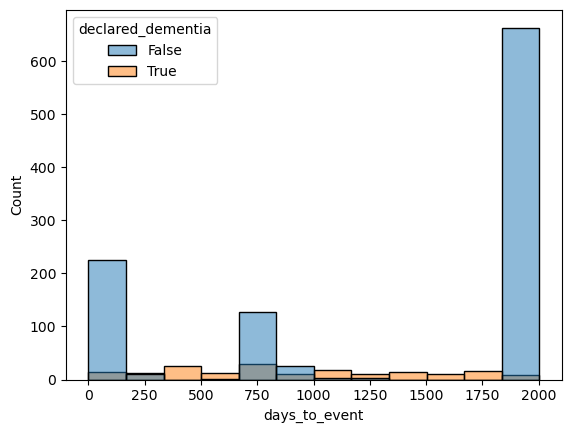

In [6]:
import seaborn as sns
sns.histplot(phenotypes, x="days_to_event", hue="declared_dementia")
plt.show()

In [7]:
days_to_scan = []
for timestep in ("M000", "M024", "M048"):
    days_to_scan.append((phenotypes[timestep] - phenotypes.INCCONSDAT_D).median().days)

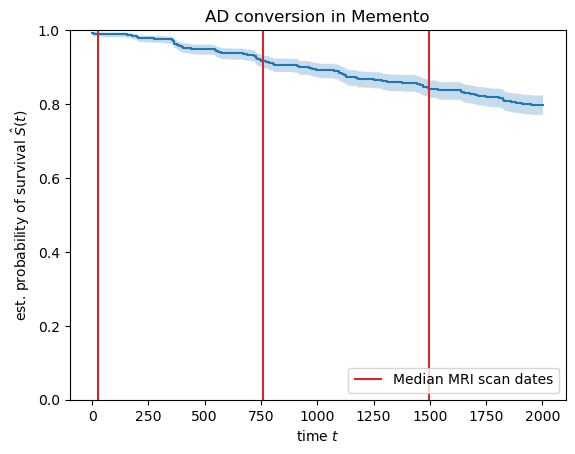

In [8]:
# TODO Give me end of following data PLEASE
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["declared_dementia"], data_y["days_to_event"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)

plt.vlines(days_to_scan, 0, 1, colors="tab:red", label="Median MRI scan dates")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="lower right")
plt.title("AD conversion in Memento")
plt.show()

In [38]:
# TODO Add sex
features = [
    "NIVETUD", "AGE_CONS", "CEN_ANOM", "MCI", "CDRSCR", "APOE_geno"
]

In [39]:
data_x[features].head()

,NIVETUD,AGE_CONS,CEN_ANOM,MCI,CDRSCR,APOE_geno
0,<= BEPC,79.6,EFW,MCI non amnésique pur,0,eps3/eps3
1,>BAC,74.4,JGX,MCI amnésique multidomaine,0.5,eps3/eps3
2,<= BEPC,70.2,QVM,MCI amnésique multidomaine,0.5,eps3/eps4
3,>BAC,77.6,JGX,MCI non amnésique multidomaine,0.5,eps3/eps3
4,>BAC,74.1,NRR,MCI non amnésique pur,0.5,eps3/eps4


In [40]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
    [
        ('categories', OneHotEncoder(dtype='float'), ['NIVETUD', "MCI", "CDRSCR", "CEN_ANOM", "APOE_geno"])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=True,
    sparse_threshold=0
)
column_trans

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('categories', OneHotEncoder(dtype='float'),
                                 ['NIVETUD', 'MCI', 'CDRSCR', 'CEN_ANOM',
                                  'APOE_geno'])])

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(
    StandardScaler(),
    CoxPHSurvivalAnalysis()
)

with warnings.catch_warnings(category=FutureWarning, action="ignore"):
    X = column_trans.fit_transform(phenotypes[features])

pipe.fit(X, data_y)


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=7.42683e-17): result may not be accurate.
  delta = solve(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=6.27164e-19): result may not be accurate.
  delta = solve(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.6202e-18): result may not be accurate.
  delta = solve(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=9.2264e-20): result may not be accurate.
  delta = solve(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=5

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis())])

In [42]:
cats = column_trans.named_transformers_["categories"].categories_
cats.append(np.array(["AGE_CONS"]))

np.hstack(cats)

array(['<= BEPC', '>BAC', 'BEP, CAP, BAC', nan,
       'MCI amnésique multidomaine', 'MCI amnésique pur',
       'MCI non amnésique multidomaine', 'MCI non amnésique pur',
       'Non MCI', '0', '0.5', 'F', nan, 'ADQ', 'CJZ', 'DOT', 'EFW', 'FEN',
       'GOX', 'HGL', 'HUH', 'ISR', 'JGX', 'KHM', 'LDK', 'LPD', 'MGP',
       'NCN', 'NRR', 'QVM', 'QYF', 'RCN', 'RQG', 'RQS', 'RXE', 'SPA',
       'UMQ', 'WBV', 'XWW', 'YLF', 'ZQY', 'eps2/eps2', 'eps2/eps3',
       'eps2/eps4', 'eps3/eps3', 'eps3/eps4', 'eps4/eps4', nan,
       'AGE_CONS'], dtype=object)

<Axes: >

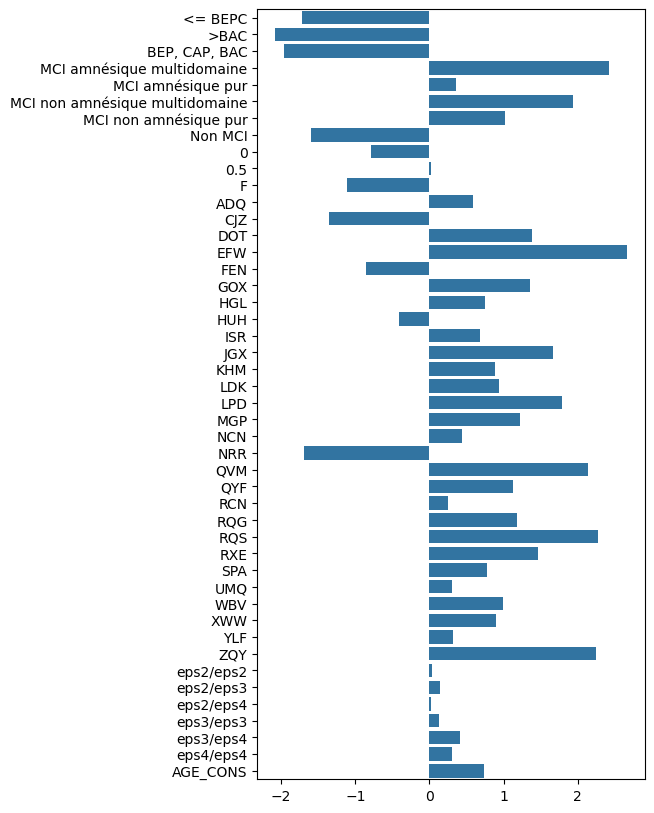

In [43]:
estimator = pipe.named_steps["coxphsurvivalanalysis"]
plt.subplots(figsize=(5, 10))
sns.barplot(
    pd.Series(estimator.coef_, index=np.hstack(cats)),
    orient="h"
)